In [1]:
from ROOT import TFile,vector
import ROOT
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from numpy import mean
from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2
from numpy import asarray
from root_pandas import read_root
from matplotlib import gridspec
from scipy import stats
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from numpy import asarray

from scipy import stats
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from textwrap import wrap
import seaborn as sns

import os

from PlottingScripts import CV, Spline, Tune1, sampHist, distVar,distplot_wratio,StackedHisto,SimpleHisto

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Welcome to JupyROOT 6.18/04


## Load  Things Up

In [2]:
#wc tagger
NUMU_RUN1_POT = 4.71579e+20
NUMU_LOWE_RUN1_POT = 1.63103516179e+21
NUE_RUN1_POT  = 9.80259e+22
RUN1_POT = 4.403e+19   #  run1
EXTRUN1_POT = (22474918.0) / float ( 9776965.0) * RUN1_POT #run1
DIRT_RUN1_POT = 2.61947e+20

NUMU_RUN3_POT = 8.98773223801e+20
NUMU_LOWE_RUN3_POT = 1.51234621011e+21
NUE_RUN3_POT = 4.70704675581e+22
RUN3_POT = 8.786e+18 # no beam quality  cut
#RUN3_POT = 1.701e+20 #1.5e20
EXTRUN3_POT = (39566274.0) / float (2263559) * RUN3_POT
#EXTRUN3_POT = (39566274.0) / float (43980680.0) * RUN3_POT


POT_SCALE_FACTOR = RUN1_POT
NUMU_RUN1_SCALE = POT_SCALE_FACTOR / float(NUMU_RUN1_POT)
NUMU_LOWE_RUN1_SCALE = POT_SCALE_FACTOR / float(NUMU_LOWE_RUN1_POT)
NUMU_RUN3_SCALE = POT_SCALE_FACTOR / float(NUMU_RUN3_POT)
NUMU_LOWE_RUN3_SCALE = POT_SCALE_FACTOR / float(NUMU_LOWE_RUN3_POT)
NUE_RUN1_SCALE = POT_SCALE_FACTOR / float(NUE_RUN1_POT)
NUE_RUN3_SCALE = POT_SCALE_FACTOR / float(NUE_RUN3_POT)
EXT_RUN1_SCALE = POT_SCALE_FACTOR / float(EXTRUN1_POT)
EXT_RUN3_SCALE = POT_SCALE_FACTOR / float(EXTRUN3_POT)
DIRT_RUN1_SCALE = POT_SCALE_FACTOR / float(DIRT_RUN1_POT)


RUN1_SCALE = POT_SCALE_FACTOR / float(RUN1_POT)
RUN3_SCALE = POT_SCALE_FACTOR / float(RUN3_POT)

print(RUN3_POT)

8.786e+18


In [3]:
tag = 'May1'

orthogonalcut = 'MaxShrFrac < .2'
precuts ='OpenAng > .5 and ChargeNearTrunk > 0 and FailedBoost != 1'# and Lepton_EdgeDist > 15 and Proton_EdgeDist > 15'
emptycut = 'Enu_1m1p > 0'

precut = orthogonalcut + ' and ' + precuts

df_numu_run1_presel = pd.read_parquet('../data/pickles/numu_run1_nodupes%s.parquet'%tag).query(precut)
df_numu_run1_presel_lowe = pd.read_parquet('../data/pickles/numu_lowe_run1_nodupes%s.parquet'%tag).query(precut)

df_numu_run3_presel = pd.read_parquet('../data/pickles/numu_run3_nodupes%s.parquet'%tag).query(precut)
df_numu_run3_presel_lowe = pd.read_parquet('../data/pickles/numu_lowe_run3_nodupes%s.parquet'%tag).query(precut)

df_nue_run1_presel = pd.read_parquet('../data/pickles/nue_run1_nodupes%s.parquet'%tag).query(precut)
df_nue_run3_presel = pd.read_parquet('../data/pickles/nue_run3_nodupes%s.parquet'%tag).query(precut)

df_ext_run1_presel = pd.read_parquet('../data/pickles/ext_run1_nodupes%s.parquet'%tag).query(precut)
df_ext_run3_presel = pd.read_parquet('../data/pickles/ext_run3_nodupes%s.parquet'%tag).query(precut)

df_data_run1_presel = pd.read_parquet('../data/pickles/data_run1_nodupes%s.parquet'%tag).query(precut)
df_data_run3_presel = pd.read_parquet('../data/pickles/data_run3_filter_nodupes%s.parquet'%tag).query(precut)

df_dirt_run1_presel = pd.read_parquet('../data/pickles/dirt_run1_nodupes%s.parquet'%tag).query(precut)

## This is where the magic happens

In [5]:
# Define signal and background for training.

nbins = 45
s_annotation = 'All Precuts, Orthogonality Cuts'

#run1
df_numu_presel = pd.concat((df_numu_run1_presel,df_numu_run1_presel_lowe))
df_signal = df_numu_presel.query("mc_label in ['numu_CCQE']")
df_extbkg = pd.concat([df_ext_run1_presel,df_dirt_run1_presel,df_numu_presel.query("mc_label in ['offvtx','nLmP','badreco']")],sort=False)
df_nubkg = df_numu_presel.query("mc_label not in ['numu_CCQE']")

#run3
#df_numu_presel = pd.concat((df_numu_run3_presel,df_numu_run3_presel_lowe,df_nue_run3_presel))
#df_signal = df_numu_presel.query("mc_label in ['numu_CCQE']")
#df_extbkg = pd.concat([df_ext_run3_presel,df_numu_presel.query("mc_label in ['offvtx','nLmP','badreco']")],sort=False)
#df_nubkg = df_numu_presel.query("mc_label not in ['numu_CCQE']")



In [44]:
# this is new! but what it does is combine all the MC stuff together so when we say Numu CCQE, it's that portion from all applicable samples all together.
# make sure to get the scales right and i'll handle the rest!
# for AddStrata, you plug in an expression to query the dataframe for a specific layer of the stacked histogram. Strata are all subsets of the MC defined before
# for AddLayer, we're adding layers to the stacked histogram that are independent from the MC defined before (EXT,dirt, etc - things that aren't split into strata)

run1Hists = StackedHisto((df_numu_run1_presel.query('MC_energyInit > 400'),df_numu_run1_presel_lowe,df_nue_run1_presel),(NUMU_RUN1_SCALE,NUMU_LOWE_RUN1_SCALE,NUE_RUN1_SCALE))
run1Hists.AddStrata("mc_label in ['numu_CCQE']",r'BNB $\nu_\mu$ CCQE','blue')
run1Hists.AddStrata("mc_label in ['numu_MEC']",r'BNB $\nu_\mu$ MEC','cyan')
run1Hists.AddStrata("mc_label in ['numu_piplusminus']",r'BNB $\nu_\mu$ Res $\pi^{+/-}$','darkgreen')
run1Hists.AddStrata("mc_label in ['numu_pizero']",r'BNB $\nu_\mu$ Res $\pi^{0}$','greenyellow')
run1Hists.AddStrata("mc_label in ['nue_CCQE']",r'$\nu_e$ Intrinsic','pink')
run1Hists.AddStrata("mc_label in ['numu_other','BNB nue_other','nue_MEC','nue_piplusminus','nue_pizero']",r'BNB Other','gold')
run1Hists.AddStrata("mc_label in ['badreco']",r'BNB Bad Reco','coral')
run1Hists.AddStrata("mc_label in ['offvtx']",r'BNB 1L1P Off Vertex','grey')
run1Hists.AddStrata("mc_label in ['nLmP']",r'BNB Not 1L1P','crimson')
run1Hists.AddLayer(df_dirt_run1_presel,DIRT_RUN1_SCALE,1,'Dirt','peru')
run1Hists.AddLayer(df_ext_run1_presel,EXT_RUN1_SCALE,0,'Cosmic Background','fuchsia')

run1DataHist = SimpleHisto(df_data_run1_presel,RUN1_SCALE,0,'','bnb5e19 [Run 1]')

run3Hists = StackedHisto((df_numu_run3_presel.query('MC_energyInit > 400'),df_numu_run3_presel_lowe,df_nue_run3_presel),(NUMU_RUN3_SCALE,NUMU_LOWE_RUN3_SCALE,NUE_RUN3_SCALE))
run3Hists.AddStrata("mc_label in ['numu_CCQE']",r'BNB $\nu_\mu$ CCQE','blue')
run3Hists.AddStrata("mc_label in ['numu_MEC']",r'BNB $\nu_\mu$ MEC','cyan')
run3Hists.AddStrata("mc_label in ['numu_piplusminus']",r'BNB $\nu_\mu$ Res $\pi^{+/-}$','darkgreen')
run3Hists.AddStrata("mc_label in ['numu_pizero']",r'BNB $\nu_\mu$ Res $\pi^{0}$','greenyellow')
run3Hists.AddStrata("mc_label in ['nue_CCQE']",r'$\nu_e$ Intrinsic','pink')
run3Hists.AddStrata("mc_label in ['numu_other','BNB nue_other','nue_MEC','nue_piplusminus','nue_pizero']",r'BNB Other','gold')
run3Hists.AddStrata("mc_label in ['badreco']",r'BNB Bad Reco','coral')
run3Hists.AddStrata("mc_label in ['offvtx']",r'BNB 1L1P Off Vertex','grey')
run3Hists.AddStrata("mc_label in ['nLmP']",r'BNB Not 1L1P','crimson')
run3Hists.AddLayer(df_dirt_run1_presel,DIRT_RUN1_SCALE,1,'Dirt','peru')
run3Hists.AddLayer(df_ext_run3_presel,EXT_RUN3_SCALE,0,'Cosmic Background','fuchsia')

run3DataHist = SimpleHisto(df_data_run3_presel,RUN3_SCALE,0,'','1m1p Open Data [Run 3]')

In [45]:
# Make big list of variables with their accompanying ranges so we can just dump a buttload of plots
varlist = []

# variable name, range, variable label, string for covariance matrix location (if applicable, or just leave blank)
varlist.append(distVar('Xreco',(15,241.25),'Reco Vertex X','../data/CovMatrices_Apr20/covar_postsel__x_reco.txt'))
varlist.append(distVar('Yreco',(-101.5,101.5),'Reco Vertex Y','../data/CovMatrices_Apr20/covar_postsel__y_reco.txt'))
varlist.append(distVar('Zreco',(15,1021.8),'Reco Vertex Z','../data/CovMatrices_Apr20/covar_postsel__z_reco.txt'))
varlist.append(distVar('Good3DReco',(0,1),'Good 3D Reco (tracker metric)'))
varlist.append(distVar('Eta',(0,.8),r'$\eta$','../data/CovMatrices_Apr20/covar_postsel__eta.txt'))
varlist.append(distVar('OpenAng',(.5,np.pi),'Opening Angle (rads)','../data/CovMatrices_Apr20/covar_postsel__openang_reco.txt'))
varlist.append(distVar('Thetas',(0,2*np.pi),r'Sum of Thetas ($\theta_{p} + \theta_{\mu}$) (rads)','../data/CovMatrices_Apr20/covar_postsel__sum_thetas_reco.txt'))
varlist.append(distVar('Phis',(0,2*np.pi),r'Sum of Phis ($\phi_{p} + \phi_{\mu}$)  (rads)','../data/CovMatrices_Apr20/covar_postsel__sum_phis_reco.txt'))
varlist.append(distVar('ChargeNearTrunk',(0,800),'ADC Charge within 5cm of Reco Vertex','../data/CovMatrices_Apr20/covar_postsel__charge_near_trunk_reco.txt'))
varlist.append(distVar('CCQEEnergyShift_1m1p',(0,5),'Energy Shift (in MeV) to Maximize QE Consistency'))
varlist.append(distVar('Enu_1m1p',(200,2000),'Reconstructed Neutrino Energy (MeV)','../data/CovMatrices_Apr20/covar_postsel__nu_energy_reco.txt'))
varlist.append(distVar('PhiT_1m1p',(0,np.pi),r'$\phi_T$','../data/CovMatrices_Apr20/covar_postsel__phiT_reco.txt'))
varlist.append(distVar('AlphaT_1m1p',(0,np.pi),r'$\alpha_T$','../data/CovMatrices_Apr20/covar_postsel__alphaT_reco.txt'))
varlist.append(distVar('PT_1m1p',(0,850),r'$p_T$','../data/CovMatrices_Apr20/covar_postsel__pT_reco.txt'))
varlist.append(distVar('PTRat_1m1p',(0,1),r'$p_T/|p|$','../data/CovMatrices_Apr20/covar_postsel__pT_ratio_reco.txt'))
varlist.append(distVar('BjX_1m1p',(0,2),'Bjorken X','../data/CovMatrices_Apr20/covar_postsel__Bjx_reco.txt'))
varlist.append(distVar('BjY_1m1p',(0,1),'Bjorken Y','../data/CovMatrices_Apr20/covar_postsel__Bjy_reco.txt'))
varlist.append(distVar('Q2_1m1p',(0,6e5),r'$Q^2$','../data/CovMatrices_Apr20/covar_postsel__Q2_reco.txt'))
varlist.append(distVar('Sph_1m1p',(0,4000),'QE Consistency','../data/CovMatrices_Apr20/covar_postsel__sph_reco.txt'))
varlist.append(distVar('PzEnu_1m1p',(-1500,400),r'$p_z - E_\nu$ (MeV)'))
varlist.append(distVar('Q0_1m1p',(70,600),r'$Q_0$','../data/CovMatrices_Apr20/covar_postsel__Q0_reco.txt'))
varlist.append(distVar('Q3_1m1p',(50,1000),r'$Q_3$','../data/CovMatrices_Apr20/covar_postsel__Q3_reco.txt'))
varlist.append(distVar('Lepton_PhiReco',(-np.pi,np.pi),r'Muon $\phi$','../data/CovMatrices_Apr20/covar_postsel__lepton_phi_reco.txt'))
varlist.append(distVar('Lepton_ThetaReco',(0,np.pi),r'Muon $\theta$','../data/CovMatrices_Apr20/covar_postsel__lepton_theta_reco.txt'))
varlist.append(distVar('Lepton_TrackLength',(5,200),'Muon Track Length (cm)','../data/CovMatrices_Apr20/covar_postsel__lepton_length_reco.txt'))
varlist.append(distVar('Muon_Edep',(20,600),'Reco Muon Energy (from range) (MeV)','../data/CovMatrices_Apr20/covar_postsel__lepton_KE_reco.txt'))
varlist.append(distVar('Proton_PhiReco',(-np.pi,np.pi),r'Proton $\phi$','../data/CovMatrices_Apr20/covar_postsel__proton_phi_reco.txt'))
varlist.append(distVar('Proton_ThetaReco',(0,np.pi),r'Proton $\theta$','../data/CovMatrices_Apr20/covar_postsel__proton_theta_reco.txt'))
varlist.append(distVar('Proton_TrackLength',(5,150),'Proton Track Length','../data/CovMatrices_Apr20/covar_postsel__proton_length_reco.txt'))
varlist.append(distVar('Proton_Edep',(50,500),'Reco Proton Energy (from range) (MeV)','../data/CovMatrices_Apr20/covar_postsel__proton_KE_reco.txt'))

In [47]:
# This will  just dump all the above variable plots with everything you want.
dumpbins = 36
dumphole = 'May7PreselTests' # where are we dumping these?

if not os.path.exists(dumphole):
    os.makedirs(dumphole)

for dist in varlist:
    fig,ax0 = distplot_wratio(dist.myname,dumpbins,dist.myrange,run1Hists,run1DataHist,dist.mylabel,normshift=.95)#cov=dist.mycovs
    #ax0.set_ylabel('Events in 1e19',fontsize=25)
    plt.savefig(dumphole+'/'+dist.myname+'.png')
    plt.close(fig)

Events: 3372.0
Min Bin ct (data): 19.0
Events: 3372.0
Min Bin ct (data): 34.0
Events: 3372.0
Min Bin ct (data): 33.0
Events: 3372.0
Min Bin ct (data): 0.0
Events: 3361.0
Min Bin ct (data): 0.0
Events: 3372.0
Min Bin ct (data): 8.0
Events: 3372.0
Min Bin ct (data): 0.0
Events: 3372.0
Min Bin ct (data): 0.0
Events: 3277.0
Min Bin ct (data): 8.0
Events: 3372.0
Min Bin ct (data): 37.0
Events: 3369.0
Min Bin ct (data): 0.0
Events: 3372.0
Min Bin ct (data): 25.0
Events: 3372.0
Min Bin ct (data): 68.0
Events: 3364.0
Min Bin ct (data): 5.0
Events: 3372.0
Min Bin ct (data): 6.0
Events: 3126.0
Min Bin ct (data): 10.0
Events: 3372.0
Min Bin ct (data): 0.0
Events: 3046.0
Min Bin ct (data): 13.0
Events: 3016.0
Min Bin ct (data): 6.0
Events: 3326.0
Min Bin ct (data): 5.0
Events: 3306.0
Min Bin ct (data): 2.0
Events: 3274.0
Min Bin ct (data): 11.0
Events: 3372.0
Min Bin ct (data): 64.0
Events: 3372.0
Min Bin ct (data): 13.0
Events: 3038.0
Min Bin ct (data): 14.0
Events: 3213.0
Min Bin ct (data): 7.0


# Weight the bdts

In [7]:
vars_cos_allofem = ['Eta','ChargeNearTrunk','PT_1m1p','PhiT_1m1p','AlphaT_1m1p','Sph_1m1p','Q0_1m1p','Q2_1m1p','Q3_1m1p','Lepton_ThetaReco','Lepton_PhiReco','Proton_ThetaReco','Proton_PhiReco','PTRat_1m1p','Lepton_TrackLength','Thetas','Phis','Proton_TrackLength','OpenAng','PzEnu_1m1p']

vars_apr14 = ['Eta','ChargeNearTrunk','PT_1m1p','PhiT_1m1p','AlphaT_1m1p','Sph_1m1p','Q0_1m1p','Q2_1m1p','Q3_1m1p','Lepton_ThetaReco','Lepton_PhiReco','Proton_ThetaReco','Proton_PhiReco','PTRat_1m1p','Lepton_TrackLength','Thetas','Phis','Proton_TrackLength','OpenAng','PzEnu_1m1p','BjX_1m1p','BjY_1m1p']

vars_may7 = ['Proton_Edep','Muon_Edep','OpenAng','Enu_1m1p','CCQEEnergyShift_1m1p','ChargeNearTrunk','PT_1m1p','PhiT_1m1p','AlphaT_1m1p','Sph_1m1p','Q0_1m1p','Q3_1m1p','Lepton_PhiReco','Proton_ThetaReco','Proton_PhiReco','PTRat_1m1p','Phis','BjX_1m1p','BjY_1m1p']

vars_may13 = ['OpenAng','Phis','ChargeNearTrunk','Enu_1m1p','PhiT_1m1p','AlphaT_1m1p','PT_1m1p','PTRat_1m1p','BjX_1m1p','BjY_1m1p','Sph_1m1p','Q0_1m1p','Q3_1m1p','Lepton_PhiReco','Lepton_TrackLength','Proton_PhiReco','Proton_ThetaReco']
myvars = vars_may13

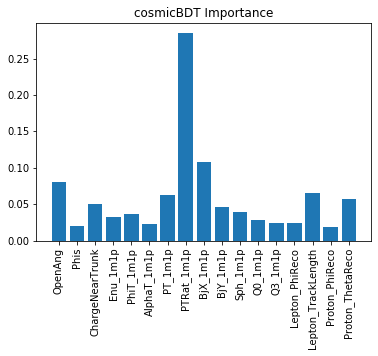

Accuracy Test:   0.9364548494983278
Accuracy Train:  0.9434769586239357
TestAcc - TrainAcc =  -0.7022109125607856


In [28]:
X = df_signal[myvars].values.tolist()
Y_cos = df_extbkg[myvars].values.tolist()

#######################################################################################################
Xl = [1 for i in range(len(X))]
Yl = [0 for i in range(len(Y_cos))]

seed = 15
test_size = 0.3
x_train, x_test, y_train, y_test = train_test_split(asarray(X+Y_cos), asarray(Xl+Yl), test_size=test_size, random_state=seed)

eval_set = [(x_train, y_train), (x_test, y_test)]
cosmicBDT = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      #colsample_bytree = .8,
                      objective='binary:logistic',
                      subsample = 0.8, 
                      n_estimators=1000, 
                      max_depth=5, 
                      gamma=5)
cosmicBDT.fit(x_train, y_train)

y_checkV = cosmicBDT.predict(x_test) #
y_checkT = cosmicBDT.predict(x_train) #
#
predictionsV = [round(value) for value in y_checkV] #
predictionsT = [round(value) for value in y_checkT] #
accuracy_diff = (accuracy_score(y_test, predictionsV)-accuracy_score(y_train,predictionsT))*100. #

fig,ax = plt.subplots(figsize=(6,4))
ax.set_title('cosmicBDT Importance')
plt.bar(range(len(cosmicBDT.feature_importances_)), cosmicBDT.feature_importances_)
plt.xticks(range(len(cosmicBDT.feature_importances_)),myvars, rotation='vertical')
plt.show()

acc_test = accuracy_score(y_test, predictionsV)
acc_train = accuracy_score(y_train,predictionsT)
accuracy_diff = (acc_test-acc_train)*100. #
print("Accuracy Test:  ",acc_test)
print("Accuracy Train: ",acc_train)
print("TestAcc - TrainAcc = ",accuracy_diff)

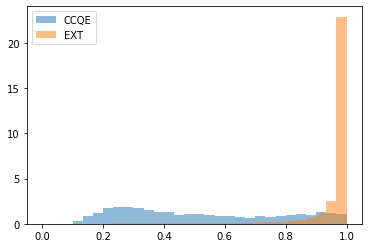

In [29]:
fig,ax = plt.subplots(figsize=(6,4))
bdt_score_ccqe = cosmicBDT.predict_proba(X)
bdt_score_ext = cosmicBDT.predict_proba(Y_cos)

_ = plt.hist(bdt_score_ccqe[:,0],30,(0,1),alpha = .5,density=1,label='CCQE')
_ = plt.hist(bdt_score_ext[:,0],30,(0,1),alpha = .5,density=1,label='EXT')

plt.legend()

In [95]:
pickle.dump(cosmicBDT,open( "../1mu1pSelection/cosmicbdt_1mu1p_mar31_ccqe.pickle", "wb" ),protocol=2)

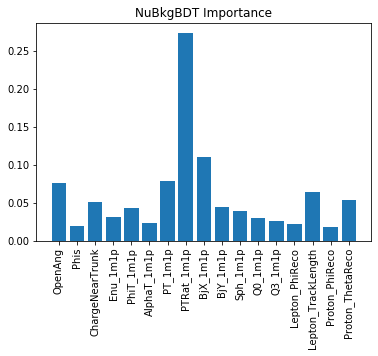

Accuracy Test:   0.931411388477877
Accuracy Train:  0.9408722228752792
TestAcc - TrainAcc =  -0.9460834397402196


In [30]:
X = df_signal[myvars].values.tolist()
Y_nubkg = df_nubkg[myvars].values.tolist()

#######################################################################################################
Xl = [1 for i in range(len(X))]
Yl = [0 for i in range(len(Y_nubkg))]

seed = 15
test_size = 0.33
x_train, x_test, y_train, y_test = train_test_split(asarray(X+Y_nubkg), asarray(Xl+Yl), test_size=test_size, random_state=seed)

eval_set = [(x_train, y_train), (x_test, y_test)]
nubkgBDT = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      #colsample_bytree = .8,
                      objective='binary:logistic',
                      subsample = 0.8, 
                      n_estimators=1000, 
                      max_depth=5, 
                      gamma=5)
nubkgBDT.fit(x_train, y_train)

y_checkV = nubkgBDT.predict(x_test) #
y_checkT = nubkgBDT.predict(x_train) #
#
predictionsV = [round(value) for value in y_checkV] #
predictionsT = [round(value) for value in y_checkT] #
accuracy_diff = (accuracy_score(y_test, predictionsV)-accuracy_score(y_train,predictionsT))*100. #

fig,ax = plt.subplots(figsize=(6,4))
ax.set_title('NuBkgBDT Importance')
plt.bar(range(len(nubkgBDT.feature_importances_)), nubkgBDT.feature_importances_)
plt.xticks(range(len(nubkgBDT.feature_importances_)),myvars, rotation='vertical')
plt.show()

acc_test = accuracy_score(y_test, predictionsV)
acc_train = accuracy_score(y_train,predictionsT)
accuracy_diff = (acc_test-acc_train)*100. #
print("Accuracy Test:  ",acc_test)
print("Accuracy Train: ",acc_train)
print("TestAcc - TrainAcc = ",accuracy_diff)


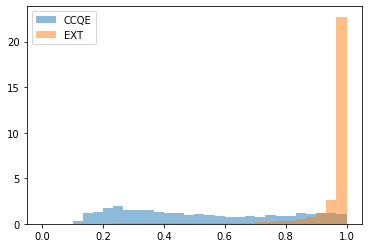

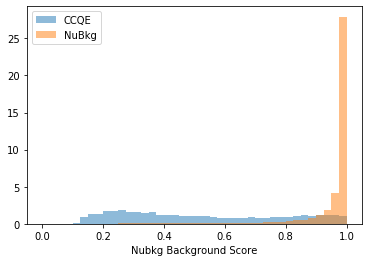

In [31]:
fig,ax = plt.subplots(figsize=(6,4))
bdt_score_ccqe = nubkgBDT.predict_proba(X)
bdt_score_ext = nubkgBDT.predict_proba(Y_cos)

_ = plt.hist(bdt_score_ccqe[:,0],30,(0,1),alpha = .5,density=1,label='CCQE')
_ = plt.hist(bdt_score_ext[:,0],30,(0,1),alpha = .5,density=1,label='EXT')

plt.legend()

fig,ax = plt.subplots(figsize=(6,4))
bdt_score_nubkg = nubkgBDT.predict_proba(Y_nubkg)

_ = plt.hist(bdt_score_ccqe[:,0],40,(0,1),alpha = .5,density=1,label='CCQE')
_ = plt.hist(bdt_score_nubkg[:,0],40,(0,1),alpha = .5,density=1,label='NuBkg')
ax.set_xlabel('Nubkg Background Score')

plt.legend()

In [28]:
bdt_score_ccqe[:,0]

array([0.29261148, 0.24616116, 0.16443151, ..., 0.40067393, 0.92871445,
       0.9880372 ], dtype=float32)

array([0.29261148, 0.24616116, 0.16443151, ..., 0.40067393, 0.92871445,
       0.9880372 ], dtype=float32)

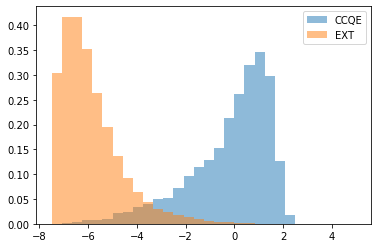

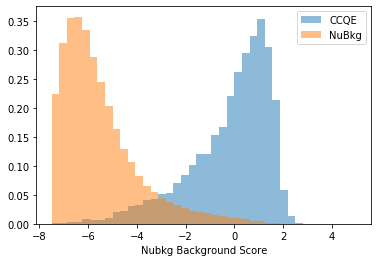

In [16]:
fig,ax = plt.subplots(figsize=(6,4))
bdt_score_ccqe = nubkgBDT.predict(X ,output_margin=True)
bdt_score_ext = nubkgBDT.predict(Y_cos,output_margin=True)

_ = plt.hist(bdt_score_ccqe,30,(-7.5,5),alpha = .5,density=1,label='CCQE')
_ = plt.hist(bdt_score_ext,30,(-7.5,5),alpha = .5,density=1,label='EXT')

plt.legend()

fig,ax = plt.subplots(figsize=(6,4))
bdt_score_nubkg = nubkgBDT.predict(Y_nubkg,output_margin=True)

_ = plt.hist(bdt_score_ccqe,40,(-7.5,5),alpha = .5,density=1,label='CCQE')
_ = plt.hist(bdt_score_nubkg,40,(-7.5,5),alpha = .5,density=1,label='NuBkg')
ax.set_xlabel('Nubkg Background Score')

plt.legend()

In [33]:
bdts = [cosmicBDT,nubkgBDT]
pickle.dump(bdts,open( "../1mu1pSelection/bdtweights_1m1p_run3_lowe_may13vars.pickle", "wb" ),protocol=2)